In [107]:
import pandas as pd
#import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
from matplotlib import ticker

%matplotlib inline

In [9]:
try:
    conn = psycopg2.connect(user = "ffunes",
                            password = "location8",
                            host = "127.0.0.1",
                            port = "5432",
                            database = "elecciones_twitter")
except:
    print("No se pudo conectar a la base de datos")

¿Cuantos Tweets tenemos?

In [3]:
pd.read_sql_query('SELECT COUNT(*) FROM tweets',con=conn)

,count
0,897531026


¿Cuantos Tweets tenemos que incluyan bounding box?

In [4]:
pd.read_sql_query('SELECT COUNT(*) FROM tweets WHERE place_bounding_box IS NOT NULL',con=conn)

,count
0,17523907


¿Cuantos Tweets tenemos que incluyan coordenadas exactas?

In [5]:
pd.read_sql_query('SELECT COUNT(*) FROM tweets WHERE coordinates IS NOT NULL',con=conn)

,count
0,1022033


¿Cuantos Tweets tenemos que incluyen un lugar de tipo ciudad?

In [6]:
pd.read_sql_query("SELECT COUNT(*) FROM tweets WHERE place_type='city'",con=conn)

,count
0,14333550


Cargamos los Tweets geolocalizados (Que incluyen un "Bounding Box") -> tweets_with_geo.
Hay que analizar el campo "coordinates" que es una coordenada precisa siempre y cuando haya tweets que contengan "coordinates" pero no "Bounding Box"

In [3]:
tweets_with_geo = gpd.GeoDataFrame.from_postgis(
    'SELECT id, user_id, place_type, place_name, place_country, place_bounding_box, coordinates FROM tweets WHERE place_bounding_box IS NOT NULL'
    , con=conn 
    , geom_col='place_bounding_box'
)

In [5]:
tweets_with_geo.head(2)

,id,user_id,place_type,place_name,place_country,place_bounding_box,coordinates
0,1166149394472812550,1147104849357672453,admin,Tucumán,Argentina,"POLYGON ((-66.16235 -28.00336, -64.47826 -28.0...",None
1,1165793794329075715,1147104849357672453,admin,Tucumán,Argentina,"POLYGON ((-66.16235 -28.00336, -64.47826 -28.0...",None


In [6]:
tweets_with_geo.place_type.value_counts()

city            14333531
admin            2524165
country           510316
poi               149729
neighborhood        6166
Name: place_type, dtype: int64

Por ahora nos importan solo las ciudades

In [7]:
tweets_with_geo = tweets_with_geo.loc[tweets_with_geo["place_type"] == "city", :]

In [8]:
tweets_with_geo.shape

(14333531, 7)

Vemos que si hay campos que incluyen coordenada especifica que no Bounding Box, son muy pocos realmente

In [ ]:
coordinates_and_not_bounding = gpd.GeoDataFrame.from_postgis(
    'SELECT * FROM tweets WHERE place_bounding_box IS NULL AND coordinates IS NOT NULL LIMIT 100000'
    , con=conn 
    , geom_col='place_bounding_box'
)

In [ ]:
coordinates_and_not_bounding.shape

Pasamos a minúsculas los campos de texto que nos importan Update: Intentamos sacar los acentos también

In [10]:
#import unidecode

def to_lower(row, column):
    if not type(row[column] == str):
        return row[column]
    
    return str(row[column]).lower()
    #return unidecode.unidecode(str(row[column]).lower())

In [10]:
tweets_with_geo["place_name"] = tweets_with_geo.apply(to_lower, axis=1, column="place_name")
tweets_with_geo["place_country"] = tweets_with_geo.apply(to_lower, axis=1, column="place_country")

In [11]:
tweets_with_geo.head(2)

,id,user_id,place_type,place_name,place_country,place_bounding_box,coordinates
5,1095400388113530880,348136446,city,mercedes,argentina,"POLYGON ((-59.46739 -34.69201, -59.39965 -34.6...",0101000020E6100000BBB88D06F0B64DC0A72215C61652...
6,1088235731548553218,348136446,city,villa gesell,argentina,"POLYGON ((-57.22167 -37.54968, -56.91513 -37.5...",0101000020E6100000F702B342917C4CC0CE5147C7D5A0...


In [12]:
tweets_with_geo["longitude_centroid"] = tweets_with_geo.geometry.centroid.x
tweets_with_geo["latitude_centroid"] = tweets_with_geo.geometry.centroid.y

In [13]:
tweets_with_geo.to_pickle('../../../../dosT/ffunes/tweets_with_geolocalization.pkl')

Incluimos geonames

In [3]:
usecols = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "population",
    "timezone",
    "country code"
]

dtypes = {
    "geonameid": np.int32,
    "name": str,
    "asciiname": str,
    "alternatenames": str,
    "latitude": np.float32,
    "longitude": np.float32,
    "feature class": str,
    "feature code": str,
    "country code": str,
    "cc2": str,
    "admin1 code": str,
    "admin2 code": str,
    "admin3 code": str,
    "admin4 code": str,
    "population": np.uint64,
    "elevation": np.float32,
    "dem": str,
    "timezone": str,
    "modification date": str    
}

In [4]:
geonames = pd.read_csv("../geonames/geonames.csv", dtype=dtypes, usecols=usecols)

In [5]:
countries_sp = pd.read_csv('../countries_csv/lista_paises_espanol.csv',
                           sep="\t",
                           names=["Code", "Name", "-"]
                          )
del countries_sp["-"]

In [6]:
countries_en = pd.read_csv('../countries_csv/lista_paises_ingles.csv',
                           sep="\t",
                           names=["Code", "Name", "-"]
                          )
del countries_en["-"]

In [7]:
countries = pd.concat([countries_sp, countries_en])

In [8]:
countries.head(2)

,Code,Name
0,AF,Afganistán
1,AL,Albania


In [11]:
countries["Name"] = countries.apply(to_lower, axis=1, column="Name")

In [12]:
countries.head(2)

,Code,Name
0,AF,afganistán
1,AL,albania


In [13]:
countries.drop_duplicates(inplace=True)

In [14]:
countries.head(2)

,Code,Name
0,AF,afganistán
1,AL,albania


In [15]:
geonames.shape

(192540, 9)

In [16]:
geonames = pd.merge(
    left=geonames,
    right=countries,
    how='inner',
    left_on='country code',
    right_on='Code'
)

In [17]:
geonames.shape

(339332, 11)

In [18]:
geonames.head()

,geonameid,name,asciiname,alternatenames,latitude,longitude,country code,population,timezone,Code,Name
0,3038999,soldeu,soldeu,NaN,42.576881,1.66769,AD,602,europe/andorra,AD,andorra
1,3039154,el tarter,el tarter,"ehl tarter,эл тартер",42.579521,1.65362,AD,1052,europe/andorra,AD,andorra
2,3039163,sant julià de lòria,sant julia de loria,"san julia,san julià,sant julia de loria,sant j...",42.463718,1.49129,AD,8022,europe/andorra,AD,andorra
3,3039604,pas de la casa,pas de la casa,"pas de la kasa,пас де ла каса",42.542770,1.73361,AD,2363,europe/andorra,AD,andorra
4,3039678,ordino,ordino,"ordino,ao er di nuo,orudino jiao qu,ордино,オルデ...",42.556229,1.53319,AD,3066,europe/andorra,AD,andorra


Separamos los distintos nombres de una ciudad y armamos un dataframe con esos nombres

In [19]:
geonames_splitted_names = (
    geonames.set_index(geonames.columns.drop('alternatenames',1).tolist())
    .alternatenames.str.split(',', expand=True)
    .stack()
    .reset_index()
    .rename(columns={0:'alternatenames'})
    .loc[:, ["alternatenames", "latitude", "longitude", "country code", "population", "Name"]]
)

KeyboardInterrupt: 

In [ ]:
geonames_splitted_names = pd.merge(
    left=geonames_splitted_names,
    right=geonames.loc[:, ["asciiname", "latitude", "longitude", "country code", "population", "Name"]].rename(columns={"asciiname": "alternatenames"}),
    how='outer'
)
geonames_splitted_names = pd.merge(
    left=geonames_splitted_names,
    right=geonames.loc[:, ["name", "latitude", "longitude", "country code", "population", "Name"]].rename(columns={"name": "alternatenames"}),
    how='outer'
)

In [ ]:
geonames_splitted_names.drop_duplicates(inplace=True)
geonames_splitted_names.shape

In [ ]:
geonames_splitted_names["alternatenames"] = geonames_splitted_names.apply(to_lower, axis=1, column="alternatenames")

In [ ]:
geonames_splitted_names.drop_duplicates(inplace=True)
geonames_splitted_names.shape

Veamos cuantos Tweets tienen el place_name contemplado en el geonames

Hay muchos lugares que incluyen mas de una latitud longitud para una misma provincia y pais (Por remover acentos, los sacamos, es ambiguo), también puede ser que sacar acentos logre que el nombre de un lugar que si lleva acento sea igual a otro que no lo lleva, es posible?

In [ ]:
geonames_splitted_names.drop_duplicates(
    subset=["alternatenames", "country code", "Name"],
    inplace=True
)
geonames_splitted_names.dropna(subset=["country code"], inplace=True)
geonames_splitted_names.shape

In [ ]:
geonames_splitted_names.head(2)

In [36]:
geonames_splitted_countries = geonames_splitted_names.groupby(
        ["alternatenames", "latitude", "longitude", "country code", "population"]
    )['Name'].apply(list).reset_index(name='countries')

In [37]:
geonames_splitted_countries.shape

(784346, 6)

In [38]:
geonames_splitted_countries.to_pickle('../../../../dosT/ffunes/geonames_splitted_countries_parsed.pkl')

In [115]:
geonames_splitted_names.rename(columns={'Name': 'country'}, inplace=True)

In [116]:
geonames_splitted_names.to_pickle('../../../../dosT/ffunes/geonames_parsed.pkl')

In [6]:
tweets_with_geo.shape

(14333531, 9)

Para asignar una coordenada exacta, vamos a tener que utilizar los bounding box para descubrir cual de todas las ciudades con el mismo nombre es a la que se refiere el Tweet. Vamos a utilizar los centroides de los bounding box


In [46]:
tweets_with_geo_and_city = pd.merge(
    left=tweets_with_geo,
    right=geonames_splitted_names,
    how='inner',
    left_on=["place_name", "place_country"],
    right_on=["alternatenames", "country"],
    validate="m:m"
)

tweets_with_geo_and_city.shape

(11913589, 15)

Distancias queda deprecado

In [8]:
def euclidean_dist(x1, x2, y1, y2):
    return pow(pow(x1-y1, 2) + pow(x2-y2, 2), 0.5)

In [9]:
tweets_with_geo_and_city["dif_distance"] = euclidean_dist(
    tweets_with_geo_and_city["latitude"],
    tweets_with_geo_and_city["longitude"],
    tweets_with_geo_and_city["latitude_centroid"],
    tweets_with_geo_and_city["longitude_centroid"]
)

In [31]:
min_distance = (tweets_with_geo_and_city
    .loc[:, ["id", "place_name", "dif_distance"]]
    .groupby(["id", "place_name"])
    .min()
    .reset_index())

tweets_with_geo_and_city = pd.merge(
    left=tweets_with_geo_and_city,
    right=min_distance,
    how='inner',
    left_on=["id", "place_name", "dif_distance"],
    right_on=["id", "place_name", "dif_distance"]
)

De los 14.000.000 Tweets, 11.913.589 incluyen paises de geonames, vemos que hay una coincidencia casi del 100%. ¿Que pasa en el resto de los casos? Geonames contiene el nombre del lugar pero de otra ciudad y, al tener menor distancia, queda esa elegida, por lo que si no coincide en ciudad, se descartarian esos datos pero en la mayoria de casos, lo que ocurre es que "country" es null por el parseo y realmente en "province" se encuentra, solo aplica para casos fuera de Argentina

In [49]:
tweets_with_geo_and_city.to_pickle('../../../../dosT/ffunes/tweets_with_geolocalization_geonames.pkl')

Veamos si la ubicacion de los usuarios es un dato confiable

¿Cuantos usuarios activos tenemos en total?

In [38]:
pd.read_sql_query('SELECT COUNT(*) FROM users',con=conn)

,count
0,2020784


In [50]:
users = pd.read_sql_query('SELECT * FROM users WHERE location IS NOT NULL',con=conn)

De los cuales aproximadamente 1 millón proveen su ubicacion en el perfil, veamos si es un dato confiable

In [51]:
users.shape

(1063795, 13)

In [52]:
users.head(3)

,id,is_private,favourites_count,followers_count,friends_count,listed_count,statuses_count,location,support,screen_name,name,loc_in_argentina,important
0,769762046539956224,False,75,48,260,1,300,"Bogotá, D.C., Colombia",juntosporelcambio,rurdanetaporti1,Rubén,no_arg,False
1,766253511482933249,False,46,1,63,0,40,"Santiago del Estero, Argentina",None,meluhjackson25,Melina Pintos,arg,True
2,769748094,False,181,88,875,1,80,"Sao Paulo, Brazil",frentedetodos,GBRInvest,GBRInvest,no_arg,False


Unificamos la información para manejar strings

In [53]:
users["location"] = users.apply(to_lower, axis=1, column="location")

Vemos que tenemos que parsear el campo de location

In [54]:
users["location"].head(10)

0            bogotá, d.c., colombia
1    santiago del estero, argentina
2                 sao paulo, brazil
3                 araure, venezuela
4            san felix. edo bolivar
5                         venezuela
6                el carmen, ecuador
7                  bogota, colombia
8      santiago del estero(capital)
9                             chile
Name: location, dtype: object

Veamos si la ubicación que incluye coincide con la mayoria de sus tweets

In [3]:
tweets_with_geo_and_city = pd.read_pickle("../../../../dosT/ffunes/tweets_with_geolocalization_geonames.pkl")

In [4]:
tweets_with_geo_and_city.columns

Index(['id', 'user_id', 'place_type', 'place_name', 'place_country',
       'place_bounding_box', 'coordinates', 'longitude_centroid',
       'latitude_centroid', 'alternatenames', 'latitude', 'longitude',
       'country code', 'population', 'Name'],
      dtype='object')

In [91]:
users_with_tweets = pd.merge(
    left=users,
    right=tweets_with_geo_and_city.loc[:, ["user_id", "place_type", "place_name", "place_country",
                                          "latitude", "longitude"]],
    how='inner',
    left_on=["id"],
    right_on=["user_id"],
    validate="1:m"
)

users_with_tweets.shape

(9291175, 19)

In [92]:
most_common_place_users = (users_with_tweets.groupby(["user_id", "place_name", "place_country"])
    .count()
    .sort_values("id", ascending=False)
    .reset_index()
    .drop_duplicates("user_id", keep='first'))

In [95]:
users_with_tweets.drop_duplicates(inplace=True)

In [98]:
users_with_tweets.shape

(324289, 19)

In [99]:
del users_with_tweets["user_id"]

In [100]:
users_with_tweets.head()

,id,is_private,favourites_count,followers_count,friends_count,listed_count,statuses_count,location,support,screen_name,name,loc_in_argentina,important,place_type,place_name,place_country,latitude,longitude
0,773970163502870528,False,974,68,312,0,647,"guadalajara de buga, colombia",frentedetodos,TaliaRada,Natalia Herrada López,no_arg,False,city,guadalajara de buga,colombia,3.900890,-76.297829
3,77573705,False,1812,314,429,6,7271,"quito, ecuador",juntosporelcambio,jjaltamirano1,Jenny Altamirano,no_arg,False,city,quito,ecuador,-0.229850,-78.524948
13,782687718576840704,False,227,5,89,0,259,"tolosa, españa",juntosporelcambio,MariaMissmu,María,no_arg,False,city,tolosa,españa,43.134838,-2.078010
30,781920345536225280,False,1294,10,202,0,142,"san pedro, argentina",juntosporelcambio,brem_yexalen,Brem Rojas Rolón,arg,True,city,san pedro,argentina,-33.679180,-59.666328
35,78502559,False,3487,52,536,0,7491,ecuador,frentedetodos,sergiosmallvill,Sergio R&R,no_arg,False,city,guayaquil,ecuador,-2.196160,-79.886208


In [106]:
users_with_location = pd.merge(
    left=users_with_tweets,
    right=most_common_place_users.loc[:, ["user_id", "place_name", "place_country"]],
    how='inner',
    left_on=["id", "place_name", "place_country"],
    right_on=["user_id", "place_name", "place_country"]
)

users_with_location.shape

(131938, 19)

In [110]:
del users_with_location["user_id"]
users_with_location.head(2)

,id,is_private,favourites_count,followers_count,friends_count,listed_count,statuses_count,location,support,screen_name,name,loc_in_argentina,important,place_type,place_name,place_country,latitude,longitude
0,773970163502870528,False,974,68,312,0,647,"guadalajara de buga, colombia",frentedetodos,TaliaRada,Natalia Herrada López,no_arg,False,city,guadalajara de buga,colombia,3.90089,-76.297829
1,77573705,False,1812,314,429,6,7271,"quito, ecuador",juntosporelcambio,jjaltamirano1,Jenny Altamirano,no_arg,False,city,quito,ecuador,-0.22985,-78.524948


Probemos asignar todos los lugares reconocidos de geonames del campo location del user

In [117]:
geonames_splitted_names = geonames_splitted_names.reset_index(drop=True)

In [118]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [119]:
geonames_splitted_names.head(1)

,alternatenames,latitude,longitude,country code,population,country
0,ehl tarter,42.579521,1.65362,AD,1052,andorra


In [120]:
position = 0
total = users_with_location.shape[0]
values = geonames_splitted_names["alternatenames"].values

def check_all_places(places, country):
    total_not_detected = 0
    total_exact = 0
    
    for place in places:
        ocurrences = np.where(values == place)[0]
        
        if len(ocurrences) == 0:
            total_not_detected += 1
            continue
        
        for index in ocurrences:
            #country_names = countries.loc[
            #                    countries["Code"] == geonames_splitted_names["country code"][index], ["Name"]
            #                ]
            country_name = geonames_splitted_names["country"][index]
            
            #if country_names.empty:
            #    continue
                
            '''country_detected = False
                
            for country_iso in country_names["Name"].values:
                if country == country_iso:
                    country_detected = True
                    total_exact += 1
                    break
            
            if country_detected:
                break'''
            if country_name == country:
                total_exact += 1
                break
    
    if total_exact == 1:
        return 'Ubicacion exacta'
    elif (total_not_detected == len(places)) | (total_exact == 0):
        return 'Ubicacion es un pais'
    return 'Ubicacion ambigua'

def es_univoco(value):
    global position;
    global total;
    global values;
    
    location = value.replace("-", ",")
    location = location.replace("/", ",")
    all_words = location.split(',')
    all_words = [word.strip() for word in all_words]
    
    update_progress(position / total)
    position += 1
    
    if len(all_words) == 1:
        place = all_words[0]
        if place in countries["Name"].values:
            return 'Ubicacion es un pais'  
        
        ocurrences = np.where(values == place)[0]
        
        if len(ocurrences) == 0:
            return 'No existe ubicacion'
        elif len(ocurrences) == 1:
            return 'Ubicacion exacta'
    
        return 'Ubicacion ambigua'
    
    #Veamos si alguna palabra es un País    
    for word in all_words:    
        if word in countries["Name"].values:
            all_words.remove(word)
            return check_all_places(all_words, word)
    
    counter = 0
        
    for word in all_words:    
        ocurrences = np.where(values == word)[0]

        if len(ocurrences) == 0:
            counter += 1
        
    if counter == len(all_words):
        return 'No existe ubicacion'
        
    return 'Ubicacion ambigua'

In [121]:
users_with_location["detected_location"] = users_with_location['location'].apply(es_univoco)

Progress: [####################] 100.0%


In [123]:
users_with_location.shape

(131938, 19)

In [126]:
users_with_location["detected_location"].value_counts()

Ubicacion exacta        54351
Ubicacion ambigua       30805
No existe ubicacion     25638
Ubicacion es un pais    21144
Name: detected_location, dtype: int64

In [127]:
print(users_with_location["detected_location"].value_counts()[0]/users_with_location.shape[0])
print(users_with_location["detected_location"].value_counts()[1]/users_with_location.shape[0])
print(users_with_location["detected_location"].value_counts()[2]/users_with_location.shape[0])
print(users_with_location["detected_location"].value_counts()[3]/users_with_location.shape[0])

0.4119434886082857
0.23348087738180054
0.194318543558338
0.16025709045157574


In [128]:
position = 0
total = users_with_location.shape[0]
values = geonames_splitted_names["alternatenames"].values

def check_all_places_determine(places, country):
    total_not_detected = 0
    total_exact = 0
    index_exact = 0
    places_determined = []
    
    for place in places:
        ocurrences = np.where(values == place)[0]
        
        if len(ocurrences) == 0:
            total_not_detected += 1
            continue
        
        for index in ocurrences:
            '''country_names = countries.loc[
                                countries["Code"] == geonames_splitted_names["country code"][index], ["Name"]
                            ]
            
            if country_names.empty:
                continue
                
            country_detected = False'''
            country_name = geonames_splitted_names["country"][index]
            
            if country == country_name:
                total_exact += 1
                places_determined.append({
                    "place": place,
                    "population":  geonames_splitted_names["population"][index],
                    "latitude":  geonames_splitted_names["latitude"][index],
                    "longitude":  geonames_splitted_names["longitude"][index]                        
                })
                break               
            '''for country_iso in country_names["Name"].values:
                if country == country_iso:
                    total_exact += 1
                    country_detected = True
                    places_determined.append({
                        "place": place,
                        "population":  geonames_splitted_names["population"][index],
                        "latitude":  geonames_splitted_names["latitude"][index],
                        "longitude":  geonames_splitted_names["longitude"][index]                        
                    })
                    break
            
            if country_detected:
                break'''
    
    if total_exact == 1:
        return [places_determined, country]
    elif (total_not_detected == len(places)) | (total_exact == 0):
        return [None, country]
    
    return [places_determined, country]

def determine_place(value):
    global position;
    global total;
    global values;
    
    location = value.replace("-", ",")
    location = location.replace("/", ",")
    all_words = location.split(',')
    all_words = [word.strip() for word in all_words]
        
    update_progress(position / total)
    position += 1
    
    if len(all_words) == 1:
        place = all_words[0]        
        if place in countries["Name"].values:
            return [None, place]
        
        ocurrences = np.where(values == place)[0]
        
        #print(place)
        
        if len(ocurrences) == 0:
            return [None, None]
        elif len(ocurrences) == 1:
            return [[{
                "place": place,
                "population":  geonames_splitted_names["population"][ocurrences[0]],
                "latitude":  geonames_splitted_names["latitude"][ocurrences[0]],
                "longitude":  geonames_splitted_names["longitude"][ocurrences[0]]
            }], None]
        
        places_determined = []
        
        for index in ocurrences:
            places_determined.append({
                "place": place,
                "population":  geonames_splitted_names["population"][index],
                "latitude":  geonames_splitted_names["latitude"][index],
                "longitude":  geonames_splitted_names["longitude"][index]                        
            })
    
        return [places_determined, None]#'Ubicacion ambigua'
    
    #Veamos si alguna palabra es un País    
    for word in all_words:    
        if word in countries["Name"].values:
            all_words.remove(word)
            return check_all_places_determine(all_words, word)

    counter = 0
    places_determined = []
        
    for word in all_words:    
        ocurrences = np.where(values == word)[0]

        if len(ocurrences) == 0:
            counter += 1
        else:
            for index in ocurrences:
                places_determined.append({
                    "place": word,
                    "population":  geonames_splitted_names["population"][index],
                    "latitude":  geonames_splitted_names["latitude"][index],
                    "longitude":  geonames_splitted_names["longitude"][index]                        
                })
        
    if counter == len(all_words):
        return [None, None]#'No existe ubicacion'
        
    return [places_determined, None]#'Ubicacion ambigua'

In [129]:
users_with_location["profile_city"], users_with_location["profile_country"] = zip(*users_with_location['location'].apply(determine_place))

Progress: [####################] 100.0%


De los usuarios que se pudo obtener el pais, coincide un 88% con la mayoria de sus tweets!

In [9]:
total = users_with_location.dropna(subset=["profile_country"]).shape[0]

a = users_with_location.dropna(subset=["profile_country"])
subtotal = a.loc[a["profile_country"] == a["place_country"], :].shape[0]

subtotal / total

0.882804146052838

De los usuarios con ubicacion exacta, coincide un 90% con la mayoria de sus tweets!

In [13]:
u = users_with_location.loc[users_with_location["detected_location"] == "Ubicacion exacta", :]
total = u.dropna(subset=["profile_country"]).shape[0]

a = u.dropna(subset=["profile_country"])
subtotal = a.loc[a["profile_country"] == a["place_country"], :].shape[0]

subtotal / total

0.9045699486194076

Veamos coincidencia para las ubicaciones exactas con las ciudades

In [14]:
def veracity(row):
    if row['profile_city'][0]['place'] == row['place_name']:
        return True
    
    return False

u = users_with_location.loc[users_with_location["detected_location"] == "Ubicacion exacta", :]
total = u.shape[0]

u["veracity"] = u.apply(veracity, axis=1)
subtotal = u.loc[u["veracity"] == True, :].shape[0]
subtotal / total

/var/home/ffunes/venv/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


0.5203768099942964

In [133]:
users_with_location.to_pickle('../../../../dosT/ffunes/users_location_parsed.pkl')

Update: Agreguemos los usuarios sin ubicacion también

In [5]:
users_no_location = pd.read_sql_query('SELECT * FROM users WHERE location IS NULL',con=conn)

In [6]:
users_no_location.shape

(956989, 13)

In [7]:
users_with_tweets = pd.merge(
    left=users_no_location,
    right=tweets_with_geo_and_city.loc[:, ["user_id", "place_type", "place_name", "place_country",
                                          "latitude", "longitude"]],
    how='inner',
    left_on=["id"],
    right_on=["user_id"],
    validate="1:m"
)

users_with_tweets.shape

(2622414, 19)

In [8]:
most_common_place_users = (users_with_tweets.groupby(["user_id", "place_name", "place_country"])
    .count()
    .sort_values("id", ascending=False)
    .reset_index()
    .drop_duplicates("user_id", keep='first'))

In [9]:
users_with_tweets.drop_duplicates(inplace=True)

In [10]:
users_with_tweets.shape

(92706, 19)

In [11]:
del users_with_tweets["user_id"]

In [12]:
users_with_no_location = pd.merge(
    left=users_with_tweets,
    right=most_common_place_users.loc[:, ["user_id", "place_name", "place_country"]],
    how='inner',
    left_on=["id", "place_name", "place_country"],
    right_on=["user_id", "place_name", "place_country"]
)

users_with_no_location.shape

(44091, 19)

In [14]:
del users_with_no_location["user_id"]

In [15]:
users_with_no_location.head(2)

,id,is_private,favourites_count,followers_count,friends_count,listed_count,statuses_count,location,support,screen_name,name,loc_in_argentina,important,place_type,place_name,place_country,latitude,longitude
0,2556507118,False,1277.0,78.0,1180.0,0.0,94.0,None,frentedetodos,juanmanube_91,Juan Manuel Báez..,None,True,city,asuncion,paraguay,-25.286461,-57.646999
1,2422744196,False,337.0,29.0,211.0,0.0,372.0,None,None,maria_fassi,"maria Fassi, Valen",None,True,city,chajarí,argentina,-30.750481,-57.979622


In [24]:
users_with_no_location["detected_location"] = "No existe ubicacion"
users_with_no_location["profile_city"] = None
users_with_no_location["profile_country"] = None

In [26]:
total_users = pd.concat([users_with_location, users_with_no_location])

In [30]:
total_users.to_pickle('../../../../dosT/ffunes/total_users_parsed.pkl')

Analizemos distancias de Tweets con campo location

In [7]:
users_with_location = pd.read_pickle('../../../../dosT/ffunes/users_location_parsed.pkl')

In [8]:
users_with_exact_location = users_with_location.loc[users_with_location["detected_location"] == "Ubicacion exacta", :]
users_with_exact_location.shape

(54351, 21)

In [9]:
from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

In [10]:
def determine_distance(row):
    profile_lat = row['profile_city'][0]['latitude']
    profile_lon = row['profile_city'][0]['longitude']
    tweet_lat = row['latitude']
    tweet_long = row['longitude']
    
    return haversine_distance(profile_lat, profile_lon, tweet_lat, tweet_long)

In [11]:
users_with_exact_location["distance_dif_in_km"] = users_with_exact_location.apply(determine_distance, axis=1)

<ipython-input-11-1b4175f9dafe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_exact_location["distance_dif_in_km"] = users_with_exact_location.apply(determine_distance, axis=1)


In [12]:
users_with_exact_location.shape

(54351, 22)

In [13]:
users_with_exact_location.loc[users_with_exact_location["distance_dif_in_km"] == 0, :].shape

(35704, 22)

In [14]:
users_with_exact_location.loc[users_with_exact_location["distance_dif_in_km"] > 0].shape

(18647, 22)

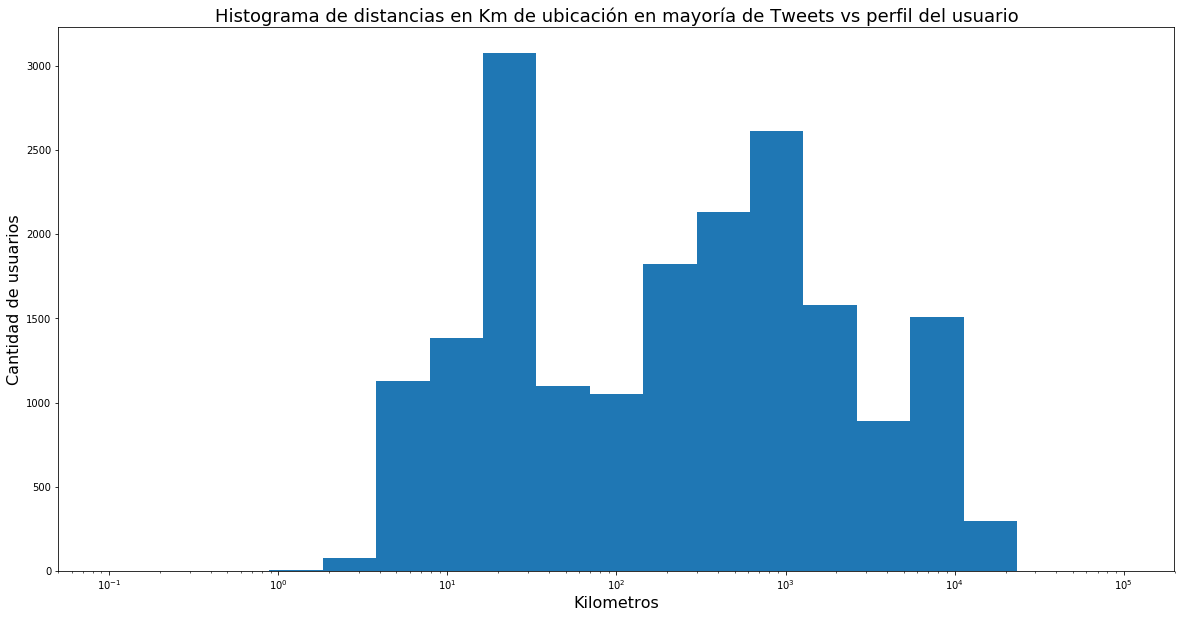

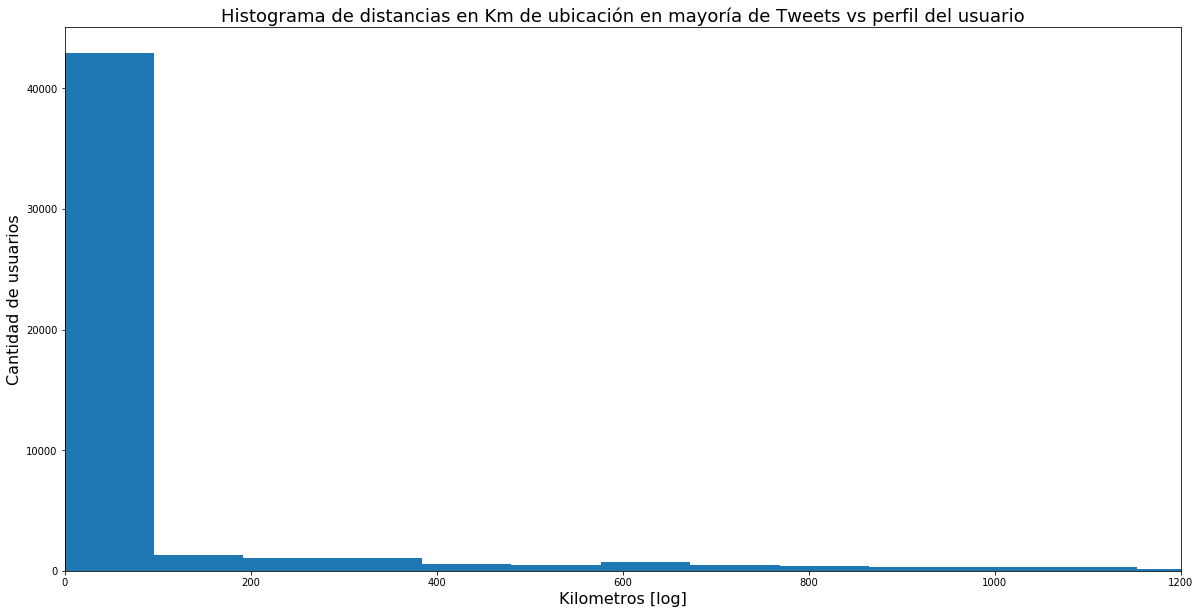

In [12]:
plt.figure(figsize=(20,10)) 
plt.hist(users_with_exact_location.loc[users_with_exact_location["distance_dif_in_km"] > 0]['distance_dif_in_km'], bins=np.logspace(-1, 5, 20))
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Histograma de distancias en Km de ubicación en mayoría de Tweets vs perfil del usuario", fontsize=18)
#plt.xlim(0, 4000)
sum(users_with_exact_location['distance_dif_in_km']<=1)
plt.xscale('log')
plt.show()

plt.figure(figsize=(20,10)) 
plt.hist(users_with_exact_location['distance_dif_in_km'], bins=200)
plt.xlabel("Kilometros [log]", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Histograma de distancias en Km de ubicación en mayoría de Tweets vs perfil del usuario", fontsize=18)
plt.xlim(0, 1200)
plt.show()

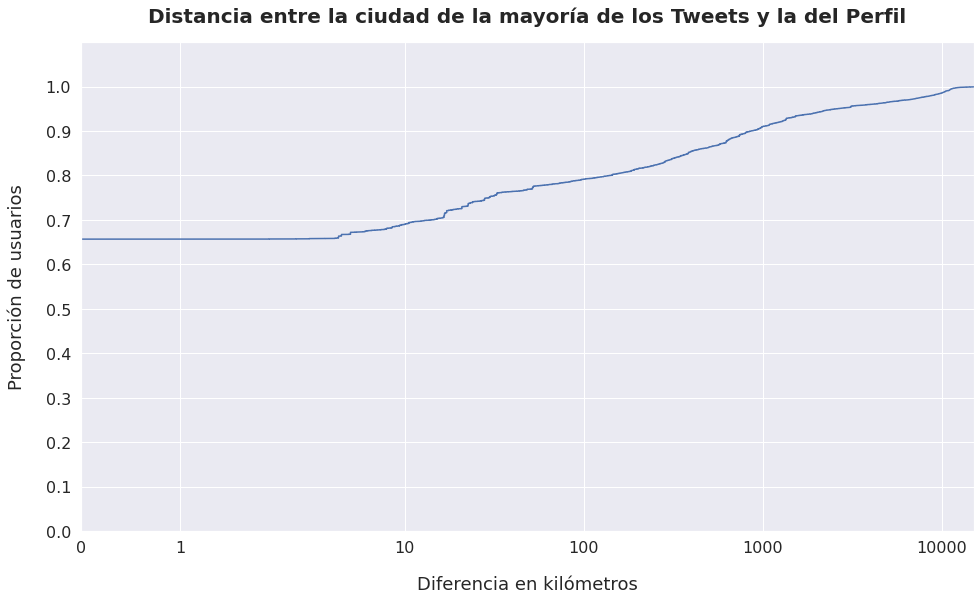

In [101]:
from matplotlib import ticker
f, ax = plt.subplots(figsize=(16, 9))

sns.set_theme()

sns.ecdfplot(
    data=users_with_exact_location["distance_dif_in_km"],
    stat="proportion",
    #log_scale=True,
    ax=ax
)

ax.set_ylim(0, 1.1)
ax.set_xlim(0, 15000)
ax.set_xscale('symlog')
ax.set_title("Distancia entre la ciudad de la mayoría de los Tweets y la del Perfil", fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel("Diferencia en kilómetros", fontsize=18, labelpad=20)
ax.set_ylabel("Proporción de usuarios", fontsize=18, labelpad=20)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

f.savefig("../results/plots/creacion_set_validacion/dif_distance_city_majority_tweets_and_profile.pdf", bbox_inches='tight')

Ahora vamos con algo más logico, que coincida el pais del perfil con el de la mayoria de los tweets

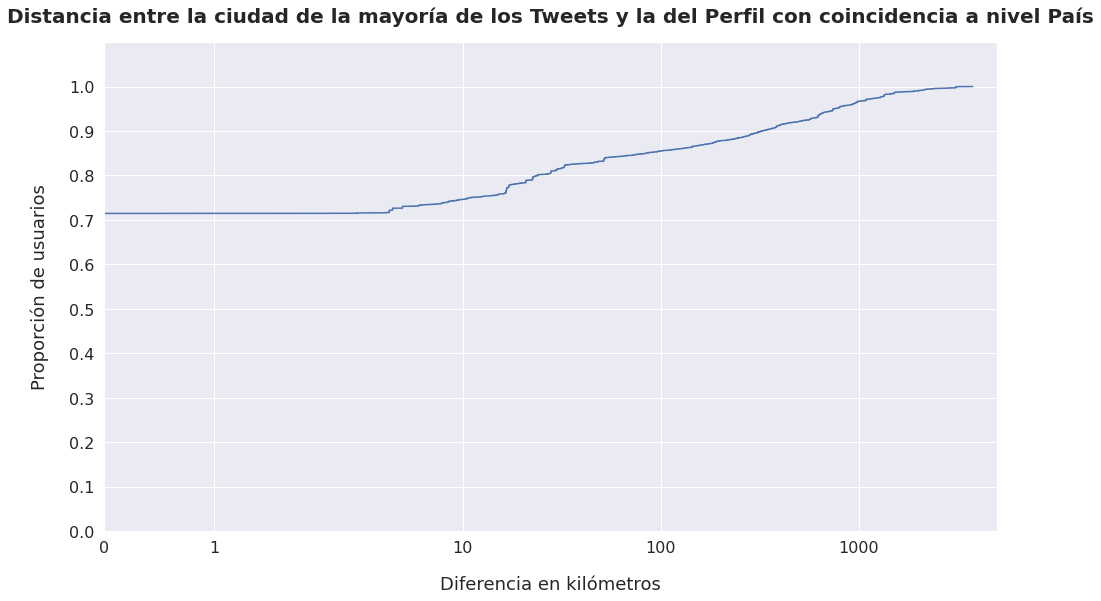

In [120]:
f, ax = plt.subplots(figsize=(16, 9))

sns.set_theme()

sns.ecdfplot(
    data=users_with_exact_location.loc
        [users_with_exact_location["place_country"] == users_with_exact_location["profile_country"]]['distance_dif_in_km'],
    stat="proportion",
    #log_scale=True,
    ax=ax
)

ax.set_ylim(0, 1.1)
ax.set_xlim(0, 5000)
ax.set_xscale('symlog')
ax.set_title("Distancia entre la ciudad de la mayoría de los Tweets y la del Perfil con coincidencia a nivel País", fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel("Diferencia en kilómetros", fontsize=18, labelpad=20)
ax.set_ylabel("Proporción de usuarios", fontsize=18, labelpad=20)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

f.savefig("../results/plots/creacion_set_validacion/dif_distance_country_majority_tweets_and_profile.pdf", bbox_inches='tight')

Veamos casos donde la ubicacion es ambigua

In [121]:
def get_closest_place_to_tweet(row):
    minor_dist = -1

    for place in row["profile_city"]:
        profile_lat = place['latitude']
        profile_lon = place['longitude']
        tweet_lat = row['latitude']
        tweet_long = row['longitude']

        new_dist = haversine_distance(profile_lat, profile_lon, tweet_lat, tweet_long)

        if (new_dist < minor_dist) | (minor_dist == -1):
            minor_dist = new_dist
    
    return minor_dist

In [122]:
users_with_ambiguous_location = users_with_location.loc[users_with_location["detected_location"] == "Ubicacion ambigua", :]
users_with_ambiguous_location.shape

(30805, 21)

In [123]:
users_with_ambiguous_location["distance_dif_in_km"] = users_with_ambiguous_location.apply(determine_distance, axis=1)

<ipython-input-123-945c613f4369>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_ambiguous_location["distance_dif_in_km"] = users_with_ambiguous_location.apply(determine_distance, axis=1)


In [142]:
users_with_ambiguous_location.loc[users_with_ambiguous_location["distance_dif_in_km"] > 0, ["location", "profile_city", "profile_country", "place_name", "place_country", "distance_dif_in_km"]]

,location,profile_city,profile_country,place_name,place_country,distance_dif_in_km
46,san francisco,"[{'longitude': -66.1253890991211, 'population'...",None,san justo,argentina,737.235325
62,"minas brasil, belo horizonte","[{'longitude': -36.82889175415039, 'population...",None,bello horizonte,brasil,1351.729251
168,porto seguro-ba; brasil,"[{'longitude': -39.064720153808594, 'populatio...",None,santa cruz cabrália,brasil,19.558944
175,caba,"[{'longitude': 76.12647247314453, 'population'...",None,ciudad autónoma de buenos aires,argentina,15830.206560
193,barquisimeto-edo lara,"[{'longitude': -69.3570327758789, 'population'...",None,cúcuta,colombia,421.906003
...,...,...,...,...,...,...
131788,buenos aires,"[{'longitude': -58.37723159790039, 'population...",None,barranquilla,colombia,5355.579948
131824,mexico city,"[{'longitude': -99.1276626586914, 'population'...",None,chandler,estados unidos,2361.165898
131827,ciudad de mexico,"[{'longitude': -99.1276626586914, 'population'...",None,benito juárez,méxico,149.972525
131838,"san francisco, córdoba","[{'longitude': -66.1253890991211, 'population'...",None,san justo,argentina,737.235325


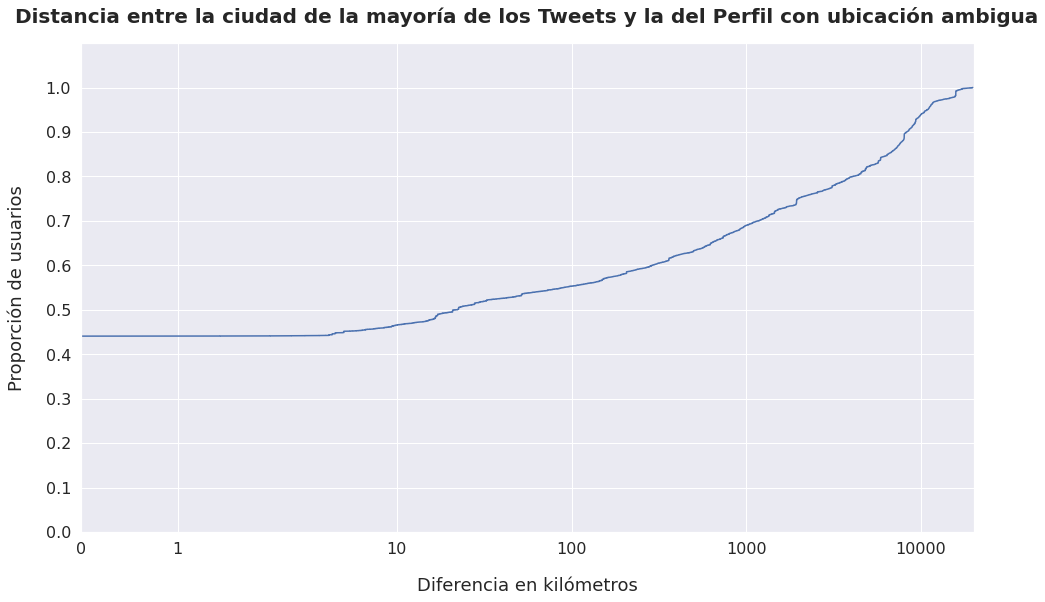

In [155]:
f, ax = plt.subplots(figsize=(16, 9))

sns.set_theme()

sns.ecdfplot(
    data=users_with_ambiguous_location["distance_dif_in_km"],
    stat="proportion",
    #log_scale=True,
    ax=ax
)

ax.set_ylim(0, 1.1)
ax.set_xlim(0, 20000)
ax.set_xscale('symlog')
ax.set_title("Distancia entre la ciudad de la mayoría de los Tweets y la del Perfil con ubicación ambigua", fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel("Diferencia en kilómetros", fontsize=18, labelpad=20)
ax.set_ylabel("Proporción de usuarios", fontsize=18, labelpad=20)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

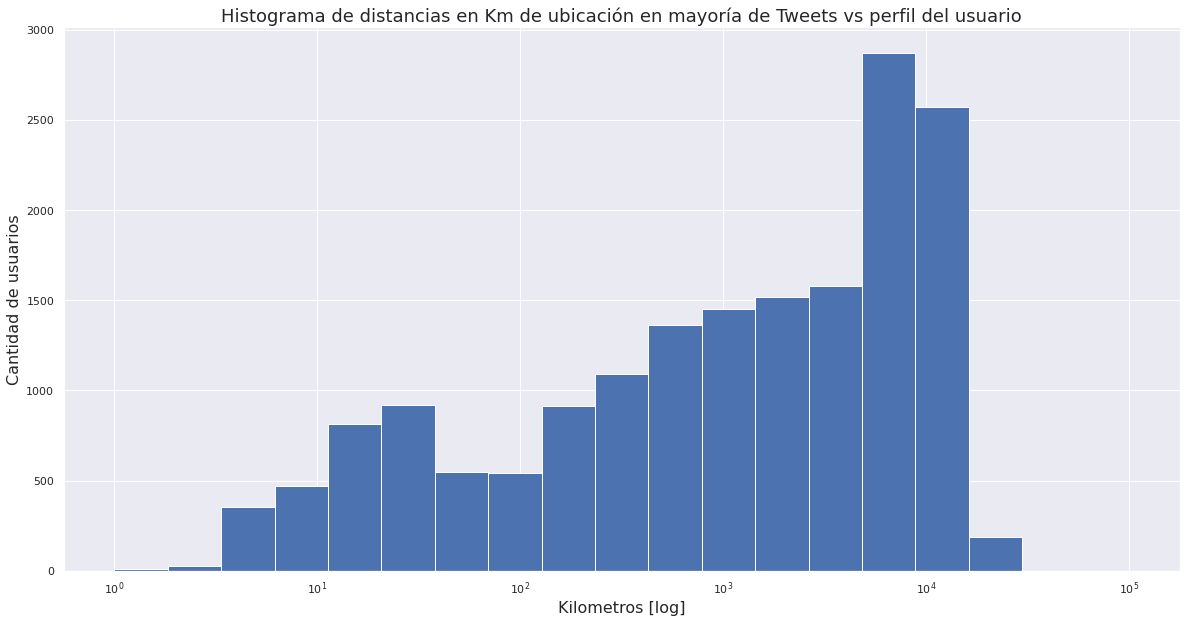

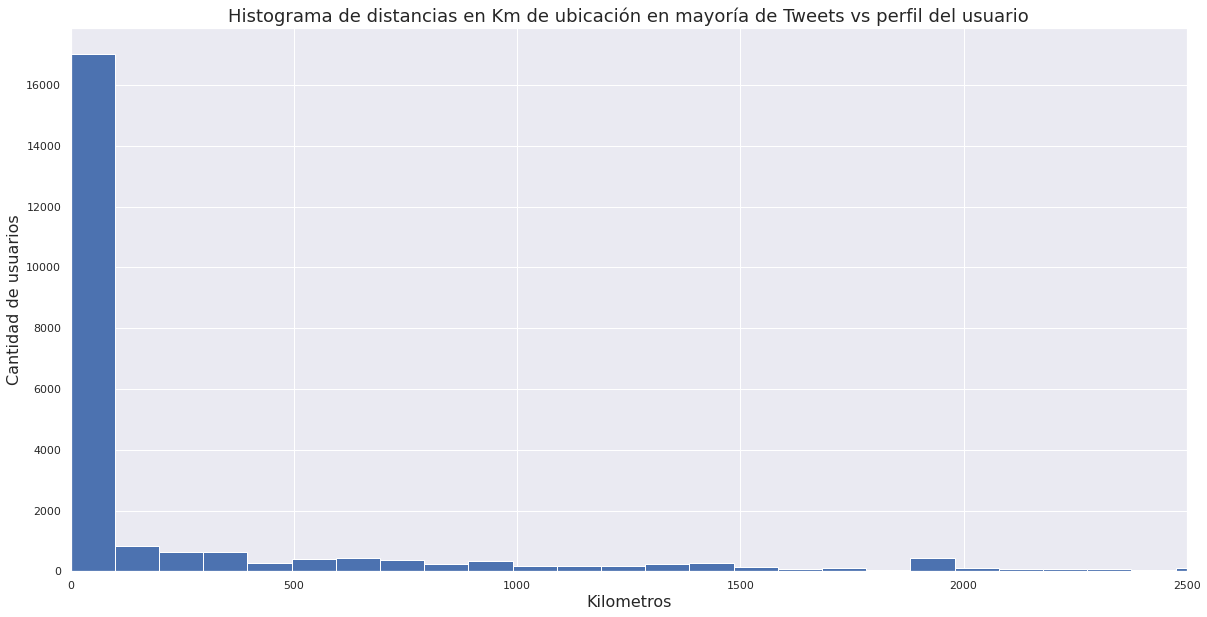

In [106]:
plt.figure(figsize=(20,10)) 
plt.hist(users_with_ambiguous_location['distance_dif_in_km'], bins=np.logspace(0, 5, 20))
plt.xlabel("Kilometros [log]", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Histograma de distancias en Km de ubicación en mayoría de Tweets vs perfil del usuario", fontsize=18)
#plt.xlim(0, 4000)
plt.figsize=(10,8)
plt.xscale('log')
plt.show()

plt.figure(figsize=(20,10)) 
plt.hist(users_with_ambiguous_location['distance_dif_in_km'], bins=200)
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Histograma de distancias en Km de ubicación en mayoría de Tweets vs perfil del usuario", fontsize=18)
plt.xlim(0, 2500)
plt.figsize=(10,8)
plt.show()

In [143]:
conn.close()
print("Sesion cerrada")

Sesion cerrada
